In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['data']


## Φόρτωση του Dataset
### Σε σχέση με τα προηγούμενα notebooks, αλλάξαμε λίγο το parsing του αρχείου με τα labels, ώστε να αποθηκεύουμε 3 τιμές στα labels του κάθε sample. Επίσης, μιας και δεν προσφέρονται τα labels για τα test data, μέσω της torch_train_val_split γυρνάμε και ένα 3ο loader, για να ελέγξουμε τη δυνατότητα γενίκευσης των μοντέλων. Minor changes, επίσης, στις συναρτήσεις __get_item__ και __len__. 

In [32]:
import copy
import gzip
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader

def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, test_size=.3, shuffle=True, seed=42): # We defined an extra parameter test_size in order to create a labeled test set (from the train data)
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    test_split = int(np.floor(test_size * val_split))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]
    test_indices = val_indices[:test_split]
    val_indices = val_indices[test_split:]
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    test_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=test_sampler)
    
    return train_loader, val_loader, test_loader


def read_spectrogram(spectrogram_file, chroma=True):
    with gzip.GzipFile(spectrogram_file, 'r') as f:
        spectrograms = np.load(f)
    # spectrograms contains a fused mel spectrogram and chromagram
    # Decompose as follows
    return spectrograms.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])

        
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1):
        self.train = train
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        if train:
            self.index = os.path.join(path, "{}_labels.txt".format(t))
            self.files, self.labels = self.get_files_labels(self.index, class_mapping)
            self.feats = [read_spectrogram(os.path.join(p, f)) for f in self.files]
            self.feat_dim = self.feats[0].shape[1]
            self.lengths = [len(i) for i in self.feats]
            self.max_length = max(self.lengths) if max_length <= 0 else max_length
            self.zero_pad_and_stack = PaddingTransform(self.max_length)
            self.label_transformer = LabelTransformer()
            self.labels = np.array(self.labels)
        else: # the labels for the test dataset were not provided
            self.files = [f for f in os.listdir('../input/data/data/multitask_dataset_beat/test')]
            self.ids = [int(str(f).rstrip().split('.')[0]) for f in self.files]
            self.feats = [read_spectrogram(os.path.join('../input/data/data/multitask_dataset_beat/test', f)) for f in self.files]
            self.feat_dim = self.feats[0].shape[1]
            self.lengths = [len(i) for i in self.feats]
            self.max_length = max(self.lengths) if max_length <= 0 else max_length
            self.zero_pad_and_stack = PaddingTransform(self.max_length)


    def get_files_labels(self, txt, class_mapping): # slightly changed (split with comma, labels now contain 3 floats)
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split(',') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = [float(l[1]), float(l[2]), float(l[3])]
            files.append(l[0] + '.fused.full.npy.gz')
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        if self.train:
            l = min(self.lengths[item], self.max_length)
            return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l
        else:
            return self.ids[item], self.zero_pad_and_stack(self.feats[item]) # there are no labels for competition data
        
    def __len__(self):
        return len(self.files) # slightly changed
      
if __name__ == '__main__':
    specs = SpectrogramDataset('../input/data/data/multitask_dataset_beat', train=True, max_length=-1)
    train_loader, val_loader, test_loader = torch_train_val_split(specs, 32 ,32, val_size=.4)
    competition = DataLoader(SpectrogramDataset('../input/data/data/multitask_dataset_beat', train=False, max_length=-1))
    #test_specs = [read_spectrogram(os.path.join('../input/data/data/multitask_dataset_beat/test', f))for f in os.listdir('../input/data/data/multitask_dataset_beat/test')]
    

## Ορισμός αρχιτεκτονικών
### Σε όλα τα μοντέλα που θα χρησημοποιήσουμε ο ορισμός μένει ίδιος (ή αρκετά παρόμοιος) με τον ορισμό στα προηγούμενα notebooks όπου κάναμε classification, με μόνη αλλαγή την έξοδο του δικτύου (από 10 σε 1) και την loss function, για την οποία πρέπει πλέον να χρησημοποιηθεί κάποια κατάλληλη για regression problem (π.χ. MSE, L1). 

In [33]:
import torch.nn as nn
torch.set_default_tensor_type(torch.DoubleTensor)

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers=1, batch_size=32, dropout=0, bidirectional=False):
        super(BasicLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = rnn_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # LSTM layer(s)
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout=dropout, bidirectional=bidirectional)
        
        # Output layer
        self.linear = nn.Sequential(nn.Linear(self.hidden_dim, output_dim),
                                    nn.Sigmoid())

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        
        lstm_out, self.hidden = self.lstm(x.view(x.shape[1], x.shape[0], x.shape[2]))
        last_out = self.last_timestep(lstm_out, lengths)
        last_outputs = self.linear(last_out.view(x.shape[0], -1, self.hidden_dim))

        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(1),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.view(outputs.shape[1], outputs.shape[0], outputs.shape[2]).gather(1, idx).squeeze()


## Lstm train & eval method

In [34]:
import scipy.stats as scp

def evalLSTM(model, loss_function, data_loader, axis, test=False):
    valscores = gold = torch.tensor([])
    ValLoss = 0
    model.eval()
    for feats, labels, lens in data_loader:
        with torch.no_grad(): 
            scores = model(feats, lens)
            valscores = torch.cat((valscores, scores.view(-1)))
            gold = torch.cat((gold, labels[:,axis]))
            if test==True and ValLoss==0: # print the 1st batch
                plt.plot(labels[:,axis].numpy(), 'ro', scores.view(-1).numpy(), 'x')
                plt.ylim(0, 1)
                plt.show()
            ValLoss += loss_function(scores.view(-1), labels[:,axis])
    metric, _ = scp.spearmanr(valscores.detach().numpy(), gold)
    
    return metric, ValLoss
            
def trainLSTM(model, loss_function, optimizer, epochs, axis):
    best_metric = 0
    for epoch in range(epochs):
        model.train()
        TrainLoss = 0
        for feats, labels, lens in (train_loader):
            model.zero_grad()
            optimizer.zero_grad()
            
            model.hidden = model.init_hidden()

            pred_labels = model(feats, lens)
            
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(pred_labels.view(-1), labels[:,axis]) #labels[:,0] for valence, labels[:,1] for energy, labels[:,2] for danceability
            TrainLoss += loss
            loss.backward()
            optimizer.step()
            
        metric, ValLoss = evalLSTM(model, loss_function, val_loader, axis)
        print("Epoch: " + str(epoch) + " || train loss: " + str(TrainLoss) + " & val loss: " + str(ValLoss))
        print("Metric is: " + str(metric))
        if metric > best_metric:
            best_metric = metric
            best_model = copy.deepcopy(model)
    
    return best_model
    

## Train for different regression axes
### Ορίζουμε ένα δίκτυο για κάθε άξονα, επιλέγουμε το καλύτερο (με βάση το validation smooth L1 loss) για τον καθένα και αποτιμάμαι στο τέλος συνολικά το regression στους 3 άξονες.
#### *Σημείωση*: παρέχεται η δυνατότητα για κάποιo, basic, transfer learning (αρχικοποιήση του δικτύου στο βελτιστο για τον προηγούμενο άξονα)

Model for 1st axis to be trained


Epoch: 0 || train loss: tensor(0.7212, grad_fn=<AddBackward0>) & val loss: tensor(0.3371)
Metric is: 0.025860223624351072
Epoch: 1 || train loss: tensor(0.7269, grad_fn=<AddBackward0>) & val loss: tensor(0.3301)
Metric is: -0.014899092063774426
Epoch: 2 || train loss: tensor(0.6624, grad_fn=<AddBackward0>) & val loss: tensor(0.3350)
Metric is: -0.05032639488886644
Epoch: 3 || train loss: tensor(0.6632, grad_fn=<AddBackward0>) & val loss: tensor(0.3290)
Metric is: 0.038979393976359744
Epoch: 4 || train loss: tensor(0.6717, grad_fn=<AddBackward0>) & val loss: tensor(0.3314)
Metric is: 0.0344251278281908
Epoch: 5 || train loss: tensor(0.6668, grad_fn=<AddBackward0>) & val loss: tensor(0.3306)
Metric is: 0.012470886583949386
Epoch: 6 || train loss: tensor(0.6482, grad_fn=<AddBackward0>) & val loss: tensor(0.3288)
Metric is: 0.022994014761622
Epoch: 7 || train loss: tensor(0.6707, grad_fn=<AddBackward0>) & val loss: tensor(0.3327)
Metric is: 0.053642235542

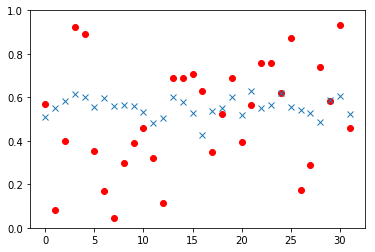

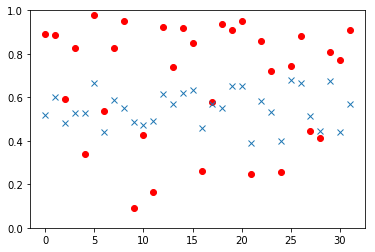

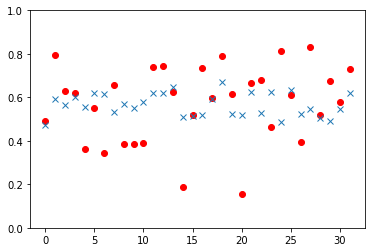

Multitask accuracy (on test set) is: 0.3349538989503335


In [35]:
# comment out the (*) labeled sentences for a basic version of transfer learning
model = BasicLSTM(input_dim=140, rnn_size=150, output_dim=1, num_layers=1)
loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print("Model for 1st axis to be trained\n\n")
model1 = trainLSTM(model, loss_function, optimizer, 10, 0)

model = BasicLSTM(input_dim=140, rnn_size=150, output_dim=1, num_layers=1) # *
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) # *
print("Model for 2nd axis to be trained\n\n")
model2 = trainLSTM(model, loss_function, optimizer, 10, 1)

model = BasicLSTM(input_dim=140, rnn_size=150, output_dim=1, num_layers=1) # *
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # *
print("Model for 3rd axis to be trained\n\n")
model3 = trainLSTM(model, loss_function, optimizer, 10, 2)

m1, _ = evalLSTM(model1, loss_function, val_loader, 0)
m2, _ = evalLSTM(model2, loss_function, val_loader, 1)
m3, _ = evalLSTM(model3, loss_function, val_loader, 2)

print("Multitask accuracy (on validation set) is: " + str((m1+m2+m3)/3))

print("Plots of 1 batch for the 3 axes")
m1, _ = evalLSTM(model1, loss_function, test_loader, 0, test=True)
m2, _ = evalLSTM(model2, loss_function, test_loader, 1, test=True)
m3, _ = evalLSTM(model3, loss_function, test_loader, 2, test=True)

print("Multitask accuracy (on test set) is: " + str((m1+m2+m3)/3)) #Check if it generalises well


# Σχολιασμός regression με LSTM
### Βλέπουμε πως τα μοντέλα μας πετυχαίνουν μέσο spearman correlation γύρω στο 0.3 (απόδοση χαμηλή). Παρατηρήσαμε κατά την εκπαίδευση και το fine tuning των hyperparameters τα εξής:
* Το regression στον 1ο άξονα αποτυγχάνει πλήρως (~0.1), αφού παράγει σχεδόν ίδιες τιμές για όλα τα samples (όπως βλέπουμε και στο 1o plot). Πιθανώς με κάποια αλλαγή των υπερπαραμέτρων να βελτιωνόταν, ωστόσο δοκιμάστηκαν MSE, L1, KL Divergence, Smooth L1 losses,  διαφορετικά μήκη μνήμης του δικτύου (rnn_size), διαφορετικοί optimizers με διαφορετικά learning rates χωρίς να παρατηρήσουμε κάποια ουσιαστική βελτίωση στο συγκεκριμένο άξονα.
* Το loss και στους 3 άξονες για το test set δεν έπεσε ποτέ κοντά στο 0 (~0.5), γεγονός που σημαίνει πως το μοντέλο αδυναμεί να εξάγει σημαντικά χαρακτηριστικά απ' τα samples.
* Για τον 2ο και τον 3ο άξονα, οι αποδόσεις βελτιώνονταν όσο ανεβάζαμε το μήκος μνήμης του δικτύου, ενώ η προσθήκη παραπάνω layers μάλλον το αποδυνάμωνε (υποθέτουμε ότι έκανε κάποιου είδους overfit) 

# Regression με τα CNN models
### Σε σχέση με τα προηγούμενα notebooks, προσθέσαμε ένα Dropout, ένα linear και μία Sigmoid στο τέλος του δικτύου, ώστε να το κάνουμε πιο εύρωστο και ρητά να τοποθετήσουμε τις τιμές στο διάστημα $ [0, 1] $.

In [36]:
class BasicCNN(nn.Module):
    def __init__(self, input_dim, output_dim, channels=[12, 24, 48, 96], kernels=[3, 3, 3, 2]):
        super(BasicCNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.channels = channels
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=self.input_dim, out_channels=channels[0], kernel_size=kernels[0]),
                                    nn.BatchNorm2d(channels[0]),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=kernels[0]))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=kernels[1]),
                                    nn.BatchNorm2d(channels[1]),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=kernels[1]))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=kernels[2]),
                                    nn.BatchNorm2d(channels[2]),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=kernels[2]))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=channels[2], out_channels=channels[3], kernel_size=kernels[3]),
                                    nn.BatchNorm2d(channels[3]),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=kernels[3]))
        self.linear = nn.Sequential(#nn.Linear(channels[3], channels[3]),
                                    #nn.Dropout(inplace=True),
                                    nn.Linear(channels[3], self.output_dim),
                                    nn.Sigmoid()
                                    )
    
    def forward(self, x):
        x = x.view(x.shape[0], self.input_dim, x.shape[2], x.shape[1])
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.shape[0], -1, self.channels[3])
        x = self.linear(x)
        
        return x

## Train & eval methods for CNN

In [37]:
def evalCNN(model, loss_function, data_loader, axis, test=False):
    valscores = gold = torch.tensor([])
    ValLoss = 0
    model.eval()
    for feats, labels, lens in data_loader:
        with torch.no_grad():
            scores = model(feats)
            valscores = torch.cat((valscores, scores.view(-1)))
            gold = torch.cat((gold, labels[:,axis]))
            if test==True and ValLoss==0: # print the 1st batch
                plt.plot(labels[:,axis].numpy(), 'ro', scores.view(-1).numpy(), 'x')
                plt.ylim(0, 1)
                plt.show()
            ValLoss += loss_function(scores.view(-1), labels[:,axis])
    metric, _ = scp.spearmanr(valscores.detach().numpy(), gold)
    
    return metric, ValLoss
            
def trainCNN(model, loss_function, optimizer, epochs, axis):
    best_metric = 0
    for epoch in range(epochs):
        model.train()
        TrainLoss = 0
        for feats, labels, lens in (train_loader):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            optimizer.zero_grad()

            # Step 3. Run our forward pass.
            pred_labels = model(feats)
            #print(pred_labels.view(-1))

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(pred_labels.view(-1), labels[:,axis])
            TrainLoss += loss
            loss.backward()
            optimizer.step()
        
        metric, ValLoss = evalCNN(model, loss_function, val_loader, axis)
        print("Epoch: " + str(epoch) + " || train loss: " + str(TrainLoss) + " & val loss: " + str(ValLoss))
        print("Metric is: " + str(metric))
        if metric > best_metric:
            best_metric = metric
            best_model = copy.deepcopy(model)
            
    return best_model



# Εκπαίδευση CNNs
### Εκπαιδεύουμε ένα διαφορετικό μοντέλο για κάθε άξονα, με μη τετραγωνικόυς kernels. Κίνητρο για την επιλογή αυτή αποτελεί η λογαριθμική κλίμακα του άξονα y στα spectrograms, καθώς και η διαφορετικού είδους πληροφορία που υπάρχει στους 2 άξονες.

Model for 1st axis to be trained

Epoch: 0 || train loss: tensor(0.7028, grad_fn=<AddBackward0>) & val loss: tensor(0.4040)
Metric is: 0.24169685611786795
Epoch: 1 || train loss: tensor(0.6406, grad_fn=<AddBackward0>) & val loss: tensor(0.2898)
Metric is: 0.33356225147779034
Epoch: 2 || train loss: tensor(0.5563, grad_fn=<AddBackward0>) & val loss: tensor(0.2922)
Metric is: 0.32243541509757523
Epoch: 3 || train loss: tensor(0.5268, grad_fn=<AddBackward0>) & val loss: tensor(0.2779)
Metric is: 0.34775511153833366
Epoch: 4 || train loss: tensor(0.4955, grad_fn=<AddBackward0>) & val loss: tensor(0.2813)
Metric is: 0.33416925439604495
Epoch: 5 || train loss: tensor(0.5351, grad_fn=<AddBackward0>) & val loss: tensor(0.3302)
Metric is: 0.2969934265618555
Epoch: 6 || train loss: tensor(0.4048, grad_fn=<AddBackward0>) & val loss: tensor(0.2894)
Metric is: 0.33710930365208663
Epoch: 7 || train loss: tensor(0.4216, grad_fn=<AddBackward0>) & val loss: tensor(0.2929)
Metric is: 0.3220392739848956


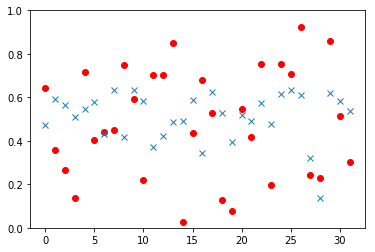

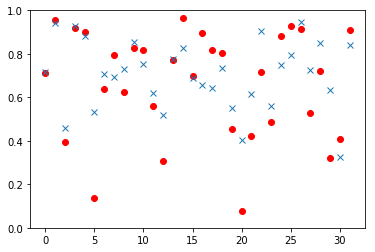

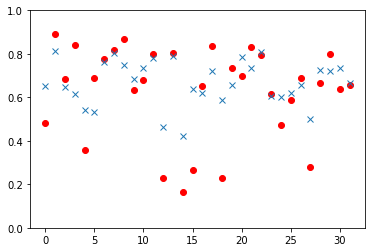

Multitask accuracy (on test set) is: 0.5665110024298783


In [38]:
# comment out the (*) labeled sentences for a basic version of transfer learning
model = BasicCNN(input_dim=1, output_dim=1, kernels=[(2,4), (1,3), 2, (13,2)])
loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Model for 1st axis to be trained\n")
model1 = trainCNN(model, loss_function, optimizer, 20, 0)

model = BasicCNN(input_dim=1, output_dim=1, kernels=[(2,4), (1,3), 2, (13,2)]) # *
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # *
print("Model for 2nd axis to be trained\n")
model2 = trainCNN(model, loss_function, optimizer, 20, 1)

model = BasicCNN(input_dim=1, output_dim=1, kernels=[(2,4), (1,3), 2, (13,2)]) # *
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # *
print("Model for 3rd axis to be trained\n")
model3 = trainCNN(model, loss_function, optimizer, 20, 2)

m1, _ = evalCNN(model1, loss_function, val_loader, 0)
m2, _ = evalCNN(model2, loss_function, val_loader, 1)
m3, _ = evalCNN(model3, loss_function, val_loader, 2)

print("Multitask accuracy (on validation set) is: " + str((m1+m2+m3)/3))

print("Plots of 1 batch for the 3 axes")


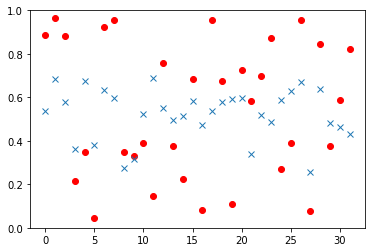

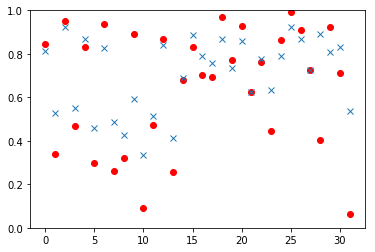

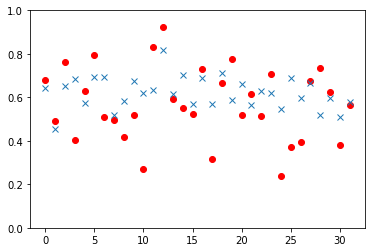

Multitask accuracy (on test set) is: 0.5978374372959642


In [39]:
m1, _ = evalCNN(model1, loss_function, test_loader, 0, test=True)
m2, _ = evalCNN(model2, loss_function, test_loader, 1, test=True)
m3, _ = evalCNN(model3, loss_function, test_loader, 2, test=True)

print("Multitask accuracy (on test set) is: " + str((m1+m2+m3)/3)) #Check if it generalises well

# Σχολιασμός αποτελεσμάτων
## Τα CNNs κρίνονται καταλληλότερα για το συγκεκριμένο task, καθώς βλέπουμε πως ρίχνουν το test loss σχεδόν στο 0 μετά από ένα μικρό (σχετικά) αριθμό εποχών, πετυχαίνοντας spearman correlation για τους 3 άξονες της τάξης του 40, 80 και 60% αντίστοιχα. Τα plots είναι οι τιμές στους 3 άξονες για ένα τυχαίο batch και βλέπουμε σημαντική εκμάθηση στον 2ο άξονα (Energy), αλλά και βελτιωμένα αποτελέσματα σε σχέση με τα LSTMs και για τους υπόλοιπους άξονες (Valence & danceability).

# Κώδικας για δημιουργία αρχείου για υποβολή στο kaggle

In [ ]:
with open("copy.txt", "w") as file:
    file.write("Id.fused.full.npy.gz,valence,energy,danceability\n")
    for ids, feats in competition:
        model1.eval()
        model2.eval()
        model3.eval()
        file.write(str(ids.item()) + '.fused.full.npy.gz,' + str((model1(feats)).item()) + ',' + str((model2(feats)).item()) + ',' + str((model3(feats)).item()) + '\n')    